2025-11-12 04:05:14.285161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 04:05:14.286682: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-12 04:05:14.291380: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-12 04:05:14.304714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762891514.329100    1009 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762891514.33


Processing Grad-CAM for CarRacing_RNNCell...



Processing Grad-CAM for CarRacing_LSTMCell...



Processing Grad-CAM for CarRacing_GRUCell...



Processing Grad-CAM for CarRacing_GRUODE...


/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/tf_keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(



Processing Grad-CAM for CarRacing_CTRNNCell...



Processing Grad-CAM for CarRacing_PhasedLSTM...



Processing Grad-CAM for CarRacing_ODELSTM...



Processing Grad-CAM for CarRacing_LTCCell...



Processing Grad-CAM for CarRacing_CfCCell...



Processing Grad-CAM for CarRacing_MultiHeadAttention...



Processing Grad-CAM for CarRacing_Attention...

Processing Grad-CAM for CarRacing_odeformer...



Processing Grad-CAM for CarRacing_CTA...



Processing Grad-CAM for CarRacing_NAC_Exact...


2025-11-12 04:05:32.848403: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Processing Grad-CAM for CarRacing_NAC_Euler...



Processing Grad-CAM for CarRacing_NAC_Steady...



Processing Grad-CAM for CarRacing_NAC_FC...



Processing Grad-CAM for CarRacing_NAC_PW...



Processing Grad-CAM for CarRacing_NAC_PWFC...


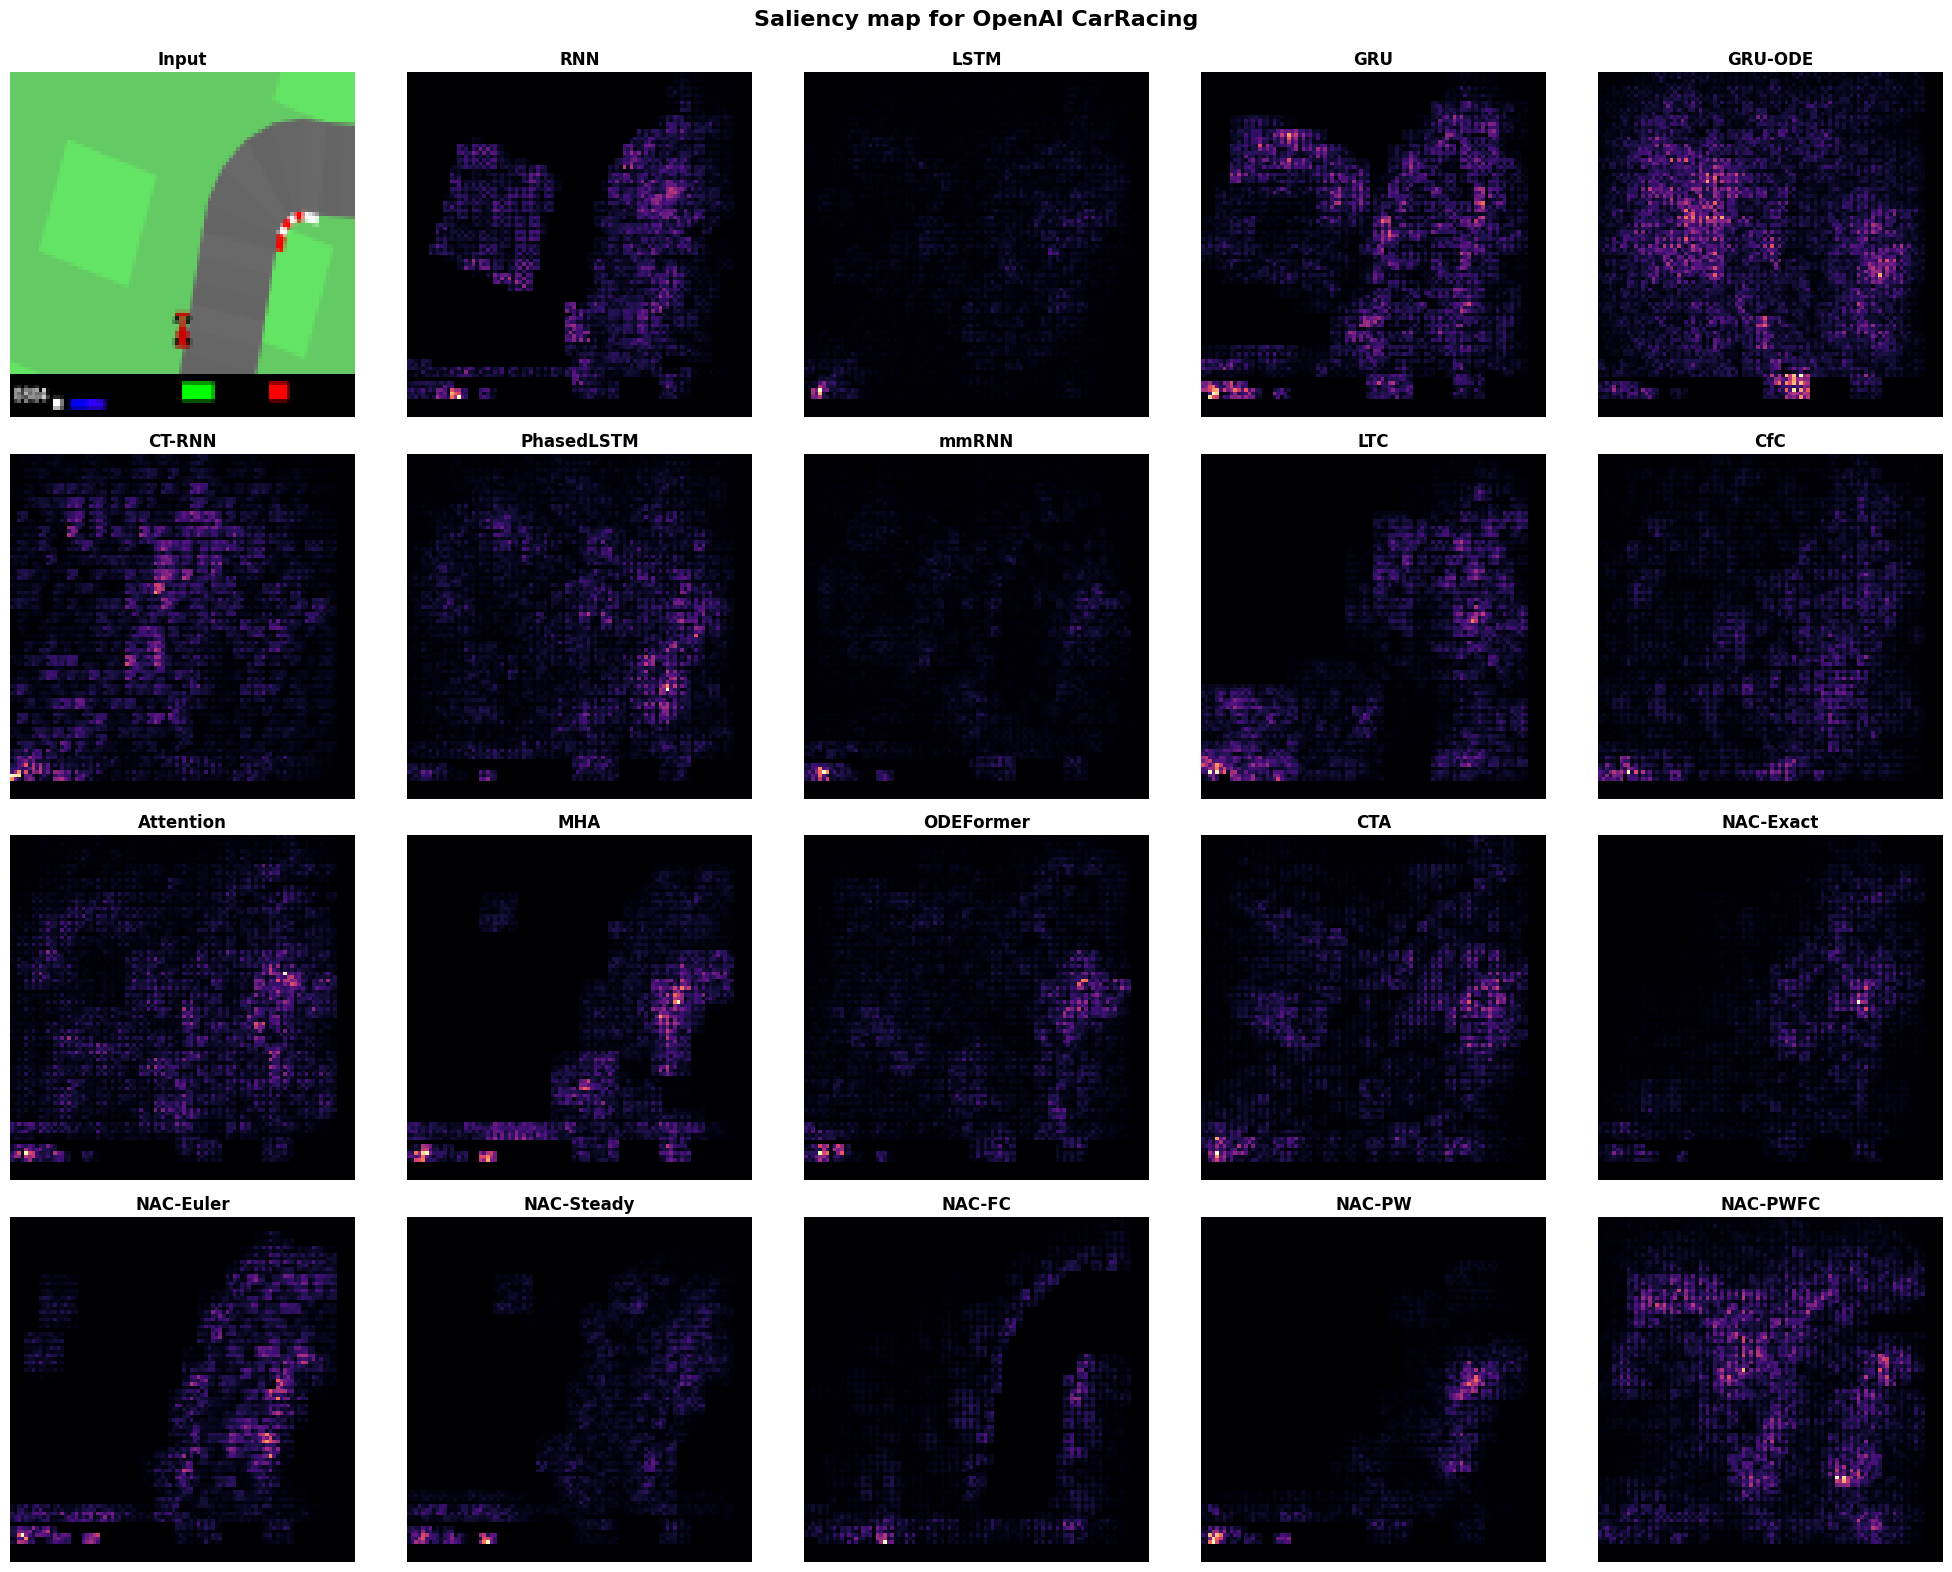

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LSTMCell, GRUCell,
    RNN, SimpleRNNCell, MultiHeadAttention, Flatten, Attention,TimeDistributed,Conv2D,Dense,Dropout
)
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from ncps.tf import LTCCell, CfCCell
from ncps.wirings import FullyConnected
from baseline_cells import CTRNNCell, ODELSTM, PhasedLSTM, GRUODE, ODEformer,CTA
from tensorflow.keras.optimizers import Adam
import pickle
import math
import matplotlib.pyplot as plt
from neuronal_attention_circuit import NAC
from NAC_with_Pairwise import NAC_PW
from NAC_with_FC import NAC_FC
from NAC_with_PWFC import NAC_PWFC



base_model_name = 'CarRacing'
weights_dir = 'model_weights'
plot_dir = 'plots'




X = []
y = []
pickle_in = open('CarRacing/data/data.pickle','rb')
data = pickle.load(pickle_in)

for obs,actions in data:
    X.append(obs)
    y.append(actions)

X_events = np.expand_dims(np.array(X),axis=1)
y = np.array(y).astype(dtype='uint8')

num_classes = len(np.unique(y))


# Wiring
wiring = FullyConnected(64)

# ---- Model builder ----
def build_model(cell_type,input_shape=(None,96,96,3), num_classes=5):
    inp = Input(shape=input_shape)
    x = TimeDistributed(Conv2D(10,(3,3),activation='relu',strides=(2,2)))(inp)
    x = TimeDistributed(Dropout(0.2))(x)
    x = TimeDistributed(Conv2D(20,(5,5),activation='relu',strides=(2,2)))(x)
    x = TimeDistributed(Dropout(0.2))(x)
    x = TimeDistributed(Conv2D(30,(5,5),activation='relu',strides=(2,2)))(x)
    x = TimeDistributed(Dropout(0.2))(x)
    x = TimeDistributed(Flatten())(x)

    if cell_type == "RNNCell":
        x = RNN(SimpleRNNCell(64), return_sequences=False)(x)
    elif cell_type == "LSTMCell":
        x = RNN(LSTMCell(64), return_sequences=False)(x)
    elif cell_type == "GRUCell":
        x = RNN(GRUCell(64), return_sequences=False)(x)
    elif cell_type == "LTCCell":
        x = RNN(LTCCell(wiring), return_sequences=False)(x)
    elif cell_type == "CfCCell":
        x = RNN(CfCCell(64), return_sequences=False)(x)
    elif cell_type == "ODELSTM":
        x = RNN(ODELSTM(64), return_sequences=False)(x)
    elif cell_type == "PhasedLSTM":
        x = RNN(PhasedLSTM(64), return_sequences=False)(x)
    elif cell_type == "GRUODE":
        x = RNN(GRUODE(64), return_sequences=False)(x)
    elif cell_type == "CTRNNCell":
        x = RNN(CTRNNCell(64, num_unfolds=5, method='euler'), return_sequences=False)(x)
    elif cell_type == "Attention":
        x = Attention()([x, x])
        x = tf.keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    elif cell_type == "MultiHeadAttention":
        x = MultiHeadAttention(num_heads=8, key_dim=64)(x,x)
        x = tf.keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    elif cell_type == "odeformer":
        x = ODEformer(hidden_dim=64, num_heads=8, ff_dim=64)(x)
        x = tf.keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(x)
    elif cell_type == "CTA":
        x = CTA(hidden_size=64)(x)
    elif cell_type == "NAC_Exact":
        x = NAC(d_model=64, num_heads=16, mode='exact',delta_t=1.5,sparsity=0.7, topk=10, return_sequences=False)(x)
    elif cell_type == "NAC_Euler":
        x = NAC(d_model=64, num_heads=16, mode='exact',delta_t=1.5,sparsity=0.7, topk=10, euler_steps=5, return_sequences=False)(x)
    elif cell_type == "NAC_Steady":
        x = NAC(d_model=64, num_heads=16, mode="steady",delta_t=1.5,sparsity=0.7, topk=10, return_sequences=False)(x)
    elif cell_type == "NAC_FC":
        x = NAC_FC(d_model=64, num_heads=16, mode="exact",delta_t=1.5, return_sequences=False)(x)
    elif cell_type == "NAC_PW":
        x = NAC_PW(d_model=64, num_heads=16, mode="exact",delta_t=1.5, return_sequences=False)(x)
    elif cell_type == "NAC_PWFC":
        x = NAC_PWFC(d_model=64, num_heads=16, mode="exact",delta_t=1.5, return_sequences=False)(x)
    else:
        raise ValueError(f"Unknown cell type: {cell_type}")
    x = Dense(64, activation="relu")(x)
    out = Dense(num_classes, activation="softmax")(x)
    return Model(inp, out)

# ---- Model types ----
model_types = [
    "RNNCell", "LSTMCell", "GRUCell",
    "GRUODE", "CTRNNCell", "PhasedLSTM",
    "ODELSTM", "LTCCell","CfCCell", 
    "MultiHeadAttention", "Attention", "odeformer","CTA",
    "NAC_Exact", "NAC_Euler", "NAC_Steady",
    "NAC_FC","NAC_PW","NAC_PWFC"
]
model_names = [
    "RNN", "LSTM", "GRU", 'GRU-ODE', 'CT-RNN', 'PhasedLSTM',
    'mmRNN', "LTC", "CfC",  "Attention", "MHA", 'ODEFormer',"CTA",
    "NAC-Exact", "NAC-Euler", "NAC-Steady",
    "NAC-FC", "NAC-PW", "NAC-PWFC",

]



# Pick a single sample
sample_idx = 15000
target_class = np.argmax(y[sample_idx])

# Original image
original_image = X_events[sample_idx]  # shape (96, 96, 3)

# Prepare input for model
frame_input = tf.convert_to_tensor(X_events[sample_idx:sample_idx+1], dtype=tf.float32)

gradcams = []

for cell_type in model_types:
    model_name = f"{base_model_name}_{cell_type}"
    print(f"\nProcessing Grad-CAM for {model_name}...")

    # Build and load model
    model = build_model(cell_type, input_shape=(None,96, 96, 3), num_classes=5)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    model.load_weights(f"{weights_dir}/{model_name}_fold1.weights.h5")

    # Compute Grad-CAM / saliency
    with tf.GradientTape() as tape:
        tape.watch(frame_input)
        output = model(frame_input)
        loss = output[:, target_class]

    grads = tape.gradient(loss, frame_input)
    saliency = tf.reduce_max(tf.abs(grads[0]), axis=-1)
    saliency /= tf.reduce_max(saliency) + 1e-8  # normalize
    saliency = saliency.numpy().squeeze()  # remove batch dim

    gradcams.append(saliency)

# ---- Plot Original Image + Grad-CAMs ----


plt.style.use('seaborn-v0_8-deep')

# Total images: original + Grad-CAMs
num_images = 1 + len(gradcams)
cols = 5
rows = math.ceil(num_images / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
#super title of figure
fig.suptitle("Saliency map for OpenAI CarRacing\n", fontsize=16, fontweight='bold')
axes = axes.flatten()  # flatten so we can index easily

# Original image
axes[0].imshow(original_image.squeeze())
axes[0].set_title("Input",fontweight='bold',fontsize=12)
axes[0].axis('off')

# Grad-CAM images
for i, saliency in enumerate(gradcams):
    axes[i + 1].imshow(original_image.squeeze(),alpha=0.55)
    axes[i + 1].imshow(saliency, cmap='magma', alpha=1.0)
    axes[i + 1].set_title(model_names[i],fontweight='bold',fontsize=12)
    axes[i + 1].axis('off')

# Hide any unused subplots
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(f'{plot_dir}/OpenAI salienymap.jpg', dpi=300)
plt.show()
